In [1]:
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
from keras.callbacks import EarlyStopping, ModelCheckpoint

import tensorflow as tf

import matplotlib.pyplot as plt
import os
import time

/opt/conda/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
batch_size = 16
num_classes = 15
epochs = 200
image_size = (224,224)
lr = 1e-5
patience = 30
validation_split = 0.1
drop_rate = 0.0

save_dir = os.path.join(os.getcwd(), 'saved_models')
# save_dir = os.path.join(os.getcwd(), 'saved_models_1556113658')
model_name = 'keras_kaggle_cnn_trained_model.h5'

In [3]:
# make tf allocate gpu memory as needed
gpu_options = tf.GPUOptions(allow_growth=True)
sess = tf.Session(config=tf.ConfigProto(gpu_options=gpu_options))

# assign the session with the previous setting as the backend of Keras
tf.keras.backend.set_session(sess)

In [4]:
print('Using real-time data augmentation.')


# train_datagen = ImageDataGenerator(
#     rescale=1./255,
# #     rotation_range=30,  # randomly rotate images in the range (degrees, 0 to 180)
# #     width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
# #     height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
# #         shear_range=0.2,
# #         zoom_range=0.2,
#     horizontal_flip=True,  # randomly flip images
#     validation_split=validation_split,
#     vertical_flip=False
#     )
train_datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='constant',
    validation_split=validation_split,
    cval=0)

train_generator = train_datagen.flow_from_directory(
        'train',
        shuffle=True,
        seed=42,
        target_size=image_size,
        batch_size=batch_size,
        class_mode='categorical',
        subset='training')


Using real-time data augmentation.
Found 2693 images belonging to 15 classes.


In [5]:
valid_datagen = ImageDataGenerator()
# valid_datagen = ImageDataGenerator(rescale=1./255)

validation_generator = train_datagen.flow_from_directory(
        'train',
        shuffle=False,
        seed=42,
        target_size=image_size,
        batch_size=1,
        class_mode='categorical',
        subset='validation')

Found 293 images belonging to 15 classes.


In [6]:
test_datagen = ImageDataGenerator() 
# test_datagen = ImageDataGenerator(rescale=1./255) 

i.shape=  (16, 224, 224, 3)
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]


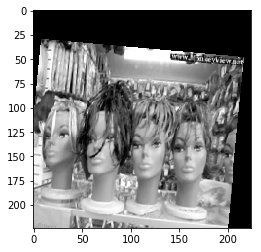

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt
i,l = next(train_generator)
print('i.shape= ', i.shape)
print(l[0])
ax = plt.imshow((i[0])/255.)

In [8]:
training_dict = train_generator.class_indices
training_dict = list(training_dict)
training_dict

['CALsuburb',
 'PARoffice',
 'bedroom',
 'coast',
 'forest',
 'highway',
 'industrial',
 'insidecity',
 'kitchen',
 'livingroom',
 'mountain',
 'opencountry',
 'store',
 'street',
 'tallbuilding']

In [9]:
kaggle_dict = {
    'CALsuburb': 9,
    'PARoffice': 7,
    'bedroom': 12,
    'coast': 10,
    'forest': 4,
    'highway': 14,
    'industrial': 2,
    'insidecity': 3,
    'kitchen': 0,
    'livingroom': 5,
    'mountain': 8,
    'opencountry': 6,
    'store': 11,
    'street': 1,
    'tallbuilding': 13 }
kaggle_dict

{'CALsuburb': 9,
 'PARoffice': 7,
 'bedroom': 12,
 'coast': 10,
 'forest': 4,
 'highway': 14,
 'industrial': 2,
 'insidecity': 3,
 'kitchen': 0,
 'livingroom': 5,
 'mountain': 8,
 'opencountry': 6,
 'store': 11,
 'street': 1,
 'tallbuilding': 13}

In [10]:
print(train_generator.n)
print(len(list(train_generator.class_indices)))
print(validation_generator.n)
print(len(list(validation_generator.class_indices)))

2693
15
293
15


In [11]:
##### print('train shape:', image_size)
print(train_generator.n, 'train samples')
print(validation_generator.n, 'test samples')

model = Sequential()

model.add(Conv2D(64, (3, 3), input_shape=(image_size[0], image_size[1],3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(drop_rate))

model.add(Conv2D(128, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(256, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(drop_rate))

model.add(Conv2D(512, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(drop_rate))

model.add(Conv2D(512, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(drop_rate))

model.add(Flatten())
model.add(Dense(128))
model.add(BatchNormalization())
model.add(Activation('relu'))


model.add(Dense(num_classes))
model.add(BatchNormalization())
model.add(Activation('softmax'))

print(model.summary())
input
# initiate Adam optimizer
opt = keras.optimizers.Adam(lr=lr)

# Let's train the model using Adam
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

# Use ModelCheckpoint to save model and weights
# if os.path.exists(save_dir):
#     timestamp = 'saved_models_{:d}'.format(int(time.time()))
#     print("file or directory with the name of ", save_dir, ' exists. use modified name : ', timestamp)
#     save_dir = os.path.join(os.getcwd(), timestamp)
#     os.makedirs(save_dir)
# else:
#     os.makedirs(save_dir)

# model_path = os.path.join(save_dir, model_name)

# checkpoint = ModelCheckpoint(model_path, monitor='val_loss', save_best_only=True, verbose=1)

# Use ModelCheckpoint to save model and weights
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
checkpoint = ModelCheckpoint(model_path, monitor='val_loss', save_best_only=True, verbose=1)

# earlystop
earlystop = EarlyStopping(monitor='val_loss', patience=patience, verbose=1)


STEPS_PER_EPOCH = train_generator.n // train_generator.batch_size
VALIDATION_STEP = validation_generator.n // validation_generator.batch_size
print('STEPS_PER_EPOCH = ', STEPS_PER_EPOCH)
print('VALIDATION_STEP = ', VALIDATION_STEP)
model_history = model.fit_generator(
                                    generator=train_generator,
                                    steps_per_epoch = STEPS_PER_EPOCH,
                                    validation_data = validation_generator, 
                                    validation_steps = VALIDATION_STEP,
                                    callbacks=[earlystop,checkpoint],
                                    workers=4,
                                    epochs = epochs
                                    )


2693 train samples
293 test samples
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 224, 224, 64)      1792      
_________________________________________________________________
batch_normalization_1 (Batch (None, 224, 224, 64)      256       
_________________________________________________________________
activation_1 (Activation)    (None, 224, 224, 64)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 112, 112, 64)      0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 112, 112, 64)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 112, 112, 128)     73856     
_________________________________________________________________
batch_normalization_2 (Batch (None, 112,

In [12]:
# loading our save model
print("Loading trained model")
model = load_model(model_path)

# Score trained model.
scores = model.evaluate_generator(generator=validation_generator)

print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

Loading trained model
Test loss: 0.9720411866095947
Test accuracy: 0.7849829351535836


In [13]:
from os import listdir
from os.path import isfile, join
import cv2
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import PIL
from PIL import Image
test_dir='testset/'

ID = []
CLASS = []

files = [join(test_dir, f) for f in listdir(test_dir) if isfile(join(test_dir, f))]

for file in files:
#     print(os.path.splitext(file)[0].split("/")[1])
#     print(file)
    ID.append(os.path.splitext(file)[0].split("/")[1])
    image = Image.open(file)
    image = image.resize(image_size)

    image = np.array(image)

#     image = image / 255.

    if image.shape == image_size:
        gray2RGB = image.reshape(image.shape[0]*image.shape[1],1)
        temp = np.hstack((gray2RGB,gray2RGB))
        gray2RGB = np.hstack((temp,gray2RGB))
        image = gray2RGB.reshape((image.shape[0],image.shape[1],3))
        image = np.expand_dims(image, axis=0)
    else:
#         print("file: ", file, " image shape = ", image.shape)
        image = np.expand_dims(image, axis=0)
    class_id = np.argmax(model.predict(image, batch_size=1))
    
    CLASS.append(kaggle_dict[training_dict[class_id]])
    
# len(ID),len(CLASS)

In [14]:
# idx = 1
# ID[idx],CLASS[idx]

In [15]:
# from os import listdir
# from os.path import isfile, join
# import cv2
# import numpy as np
# from matplotlib import pyplot as plt
# import pandas as pd
# import PIL
# from PIL import Image


# file = '/home/jovyan/my-workspace/Kaggle_CNN/testset/d9d914fae34406fb2e6e2d3c97fe33b9319733fd121b00ed2acff8be772f1e7e.jpg'

# image = Image.open(file)
# image = image.resize(image_size)
# plt.imshow(image)
# image = np.array(image)
# image = image / 255.

# gray2RGB = image.reshape(image.shape[0]*image.shape[1],1)
# temp = np.hstack((gray2RGB,gray2RGB))
# gray2RGB = np.hstack((temp,gray2RGB))
# image = gray2RGB.reshape((image.shape[0],image.shape[1],3))
# image = np.expand_dims(image, axis=0)
# class_id = kaggle_dict[training_dict[np.argmax(model.predict(image, batch_size=1))]]
# print("class= ", class_id)
    

In [16]:
solution = pd.DataFrame({"ID":ID, "class":CLASS})
solution.to_csv("submission.csv", index = False)